# Use Black-Litterman model to get a posterior estimation of stocks' return
# Use sentiment score from alphavantage as views 

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [75]:
tickers = ["AAPL", "AMZN", "META", "NFLX", "NVDA", "TSLA"]
ohlc = yf.download(tickers, period="max") # start = "2010-01-01", end="2018-01-01")
prices = ohlc["Adj Close"]

# SPY: SPDR S&P 500 ETF Trust. It is designed to track the S&P 500 stock market index. This fund is the largest and oldest ETF in the USA.
market_prices = yf.download("SPY", period="max")["Adj Close"]
# market_prices.head()

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  1 of 1 completed


# Calculate the market implied prior returns

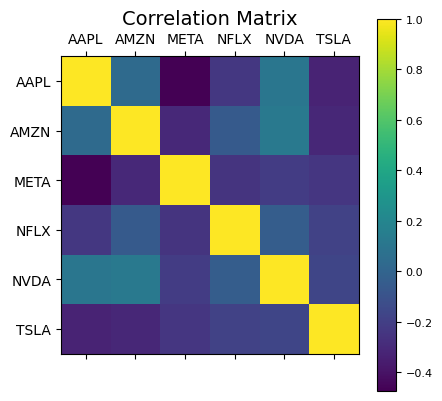

In [76]:
import pypfopt
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel

mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf() # Covariance Matrix of asset returns

# Plot correlation matrix
plt.matshow(S.corr())
plt.xticks(range(S.select_dtypes(['number']).shape[1]), S.select_dtypes(['number']).columns, fontsize=10)
plt.yticks(range(S.select_dtypes(['number']).shape[1]), S.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=14)

delta = black_litterman.market_implied_risk_aversion(market_prices) # Prior estimate of returns, calculated by the market’s excess return divided by its variance: (R-R_f)/sig^2
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

# Use sentiment score from alphavantage to calculate the veiws
Use sentiment score gamma to calculate new stock price

  $$ S_T=   \left\{
\begin{array}{ll}
      S_0+[(S_{MC}^+ -S_0) \cdot \gamma] & \text{ if }  \gamma \text{ in } (0, 1] \\
      S_0-[(S_0 - S_{MC}^-) \cdot  \gamma] & \text{ if } \gamma \text{ in } [-1, 0) \\
\end{array} 
\right.  $$
We need to use Monte Carlo to simulate possible stock prices to get $S_{MC}^-$ and $S_{MC}^+$.

Then 
$$Views= \ln (\frac{S_T}{S_0})$$

In [77]:
def get_data(ticker):
    df_news = pd.read_csv(f'../data/{ticker}_news_data.csv', index_col='date',parse_dates=True,dtype=float)
    return df_news
# use the average of sentiment score from the last 10 days 
sentiment = {}
confidences = []
for ticker in tickers:
    sentiment[ticker] = get_data(ticker)['sentiment_score'][-10:].mean()
    confidences.append(get_data(ticker)['relevance_score'][-10:].mean())

In [78]:
sentiment

{'AAPL': 0.2028133526917646,
 'AMZN': 0.20648308892020723,
 'META': 0.09771996494035207,
 'NFLX': 0.21834471492682184,
 'NVDA': 0.1999117861767659,
 'TSLA': 0.1703159045557398}

## Monte Carlo simulation for stock prices

In [79]:
# Calculate log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Estimate parameters
mean_return = log_returns.mean()
volatility = log_returns.std()

# Monte Carlo simulation parameters
num_simulations = 1000
num_days = 5  # Number of trading days in a year

# Step 4: Simulate future prices
def monte_carlo_simulation(start_price, mean_return, volatility, num_days, num_simulations):
    simulated_prices = np.zeros((num_days, num_simulations))
    simulated_prices[0] = start_price

    for t in range(1, num_days):
        random_shocks = np.random.normal(loc=mean_return, scale=volatility, size=num_simulations)
        simulated_prices[t] = simulated_prices[t - 1] * np.exp(random_shocks)
    
    return simulated_prices

def NewStockPrice(gamma, S, S0):
    if gamma <0:
        S_T= S0 - (S0 - S.min())*gamma
    else:
        S_T= S0 + (S.max() - S0)*gamma
    return S_T


## calculate the views

In [89]:
viewdict = {}
for ticker in tickers:
    start_price = prices[ticker].iloc[-1]
    simulated_prices = monte_carlo_simulation(start_price, mean_return[ticker], volatility[ticker], num_days, num_simulations)
    ST = NewStockPrice(sentiment[ticker], simulated_prices, start_price)
    viewdict[ticker] = (ST-start_price)/ST
    # viewdict[ticker] = np.log(ST/start_price)


In [90]:
viewdict

{'AAPL': 0.018964873531151474,
 'AMZN': 0.028263448827409554,
 'META': 0.01943136246396667,
 'NFLX': 0.043169355105886424,
 'NVDA': 0.05505086060919889,
 'TSLA': 0.0388965050339289}

In [91]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

Posterior Estimates 

In [92]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()

rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.269684,0.168149,0.018965
AMZN,0.217663,0.137141,0.028263
META,0.078055,0.057541,0.019431
NFLX,0.120536,0.079239,0.043169
NVDA,0.284824,0.198010,0.055051
TSLA,0.097764,0.067922,0.038897


<Axes: >

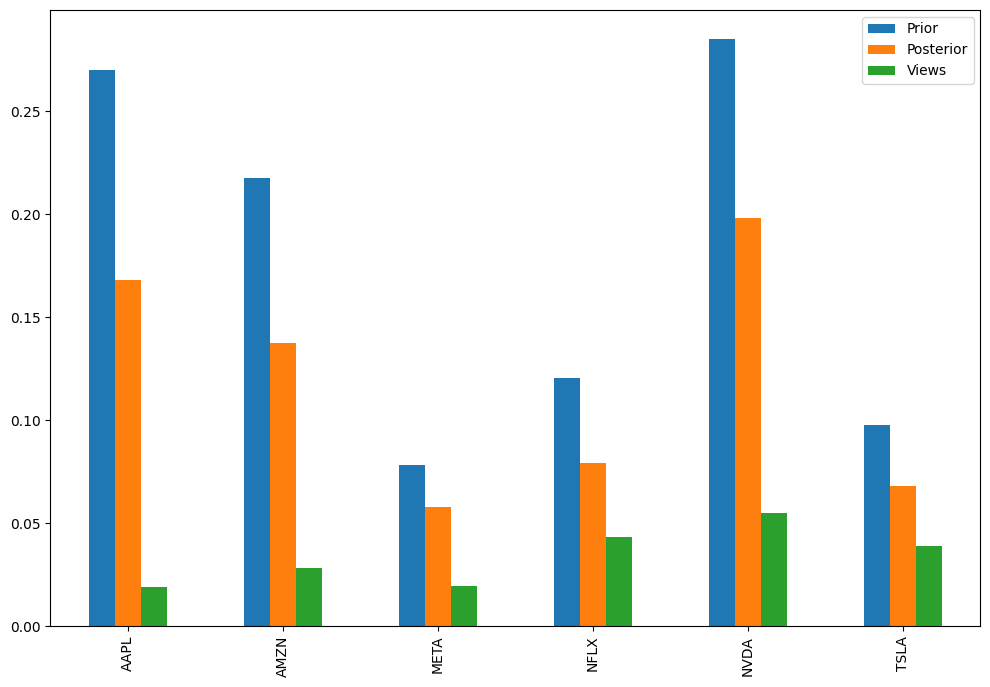

In [93]:
rets_df.plot.bar(figsize=(12,8))

# Portfolio optimization by mean-variance 

In [88]:
from pypfopt import EfficientFrontier, objective_functions
# Optimize for maximal Sharpe ratio
# Long/short: by default all of the mean-variance optimization methods in PyPortfolioOpt are long-only, but they can be initialised to allow for short positions by changing the weight bounds:ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
S_bl = bl.bl_cov()
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.26226),
             ('AMZN', 0.19316),
             ('META', 0.06642),
             ('NFLX', 0.09033),
             ('NVDA', 0.30581),
             ('TSLA', 0.08203)])

In [ ]:
# compare the results 